# Stochastic Local Volatility Models

In [19]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import rivapy.pricing.analytics
import rivapy.models as models
import rivapy.marketdata as mktdata
import rivapy.pricing.analytics

%matplotlib inline
#reload modules 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Global Settings

In [2]:
strikes = np.linspace(0.7, 1.3, 50)
timegrid = np.linspace(0.0,3.0,3*365)

## Helper Functions

In [3]:
def calc_imlied_vol_grid(expiries, strikes, call_prices):
    vols = np.zeros((expiries.shape[0],strikes.shape[0]))
    for i in range(expiries.shape[0]):
        for j in range(strikes.shape[0]):
            try:
                vols[i,j] = rivapy.pricing.analytics.compute_implied_vol_Buehler(strikes[j], maturity=expiries[i], 
                                                                  price=call_prices[i, j], min_vol=0.01)
            except:
                pass
        
    for i in range(expiries.shape[0]):
        extrapolation = False
        for j in range(int(strikes.shape[0]/2),strikes.shape[0]):
            if vols[i,j] <1e-1:
                vols[i,j] = vols[i,j-1]
                extrapolation = True
        for j in range(23,-1,-1):
            if vols[i,j] <1e-6:
                vols[i,j] = vols[i,j+1]
                extrapolation = True
        if extrapolation:
            print('Extrapolation necessary for expiry ' + str(i))
    return vols

## Local-Vol

In [3]:
ssvi = mktdata.VolatilityParametrizationSSVI(expiries=[1.0/365, 30/365, 0.5, 1.0], fwd_atm_vols=[0.25, 0.3, 0.28, 0.25], rho=-0.9, eta=0.5, gamma=0.5)
local_var = models.LocalVol.compute_local_var(ssvi, strikes, timegrid)

## Heston

In [415]:
heston = models.HestonModel(long_run_variance=0.3**2, 
                            mean_reversion_speed=0.5, 
                            vol_of_vol=0.2, 
                            initial_variance=0.15**2, 
                            correlation = -0.95)

In [152]:
# compute implied vols for a fixed set of heston parameters

In [416]:
n_sims = 100_000
S0 = 1.0

simulated_values = np.empty((n_sims, 2))
simulated_values[:,0] = S0
simulated_values[:,1] = heston._initial_variance

paths = np.empty((timegrid.shape[0], n_sims, 2))
paths[0] = simulated_values

t0 = timegrid[0]
np.random.seed(42)

for i in range(1,timegrid.shape[0]):
    rnd = np.random.normal(size=(n_sims,2))
    paths[i] = heston.apply_mc_step(simulated_values, t0, timegrid[i], rnd, inplace = True)
    t0 = timegrid[i]

In [226]:
if False:
    index = 2*365-1
    x = paths[index][:1000,0:1]
    y = paths[index][:1000,1]
    #x_test = paths[index]#[500:,0:1]
    #y_test = paths[index]#[500:,1]

    gammas = [0.01, 0.1, 1.0, 10.0, 18, 30, 100, 500, 1000]
    mse = []
    #for gamma in gammas:
    kr = rivapy.numerics.kernel_regression.KernelRegression( gamma=[46]).fit(x,y)
    estimate = kr.predict(x)
    #    mse.append(np.mean(np.square(estimate-y_test)))
    plt.plot(i,((4.0*np.std(paths[index][:1000,0])**5)/paths.shape[1])**(-1.0/5.0),'.')
    plt.plot(paths[index][:,0],paths[index][:,1],'.')
    plt.plot(x,y,'.')

    plt.plot(x,estimate,'.')

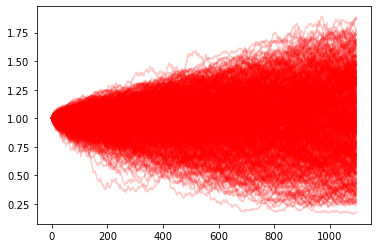

In [417]:
for i in range(500):
    plt.plot(paths[:,i,0],'-r', alpha=0.2)


expiries = timegrid[10::30]
p = paths[10::30]
call_prices = np.empty((expiries.shape[0], strikes.shape[0]))

for i in range(expiries.shape[0]):
    for k in range(strikes.shape[0]):
        #print(np.mean(np.maximum(paths[10::30][i][:,0]-strikes[k],0.0)))
        call_prices[i,k] = np.mean(np.maximum(p[i][:,0]-strikes[k],0.0))

In [418]:
vols_heston = calc_imlied_vol_grid(expiries, strikes, call_prices)         

Extrapolation necessary for expiry 0
Extrapolation necessary for expiry 1
Extrapolation necessary for expiry 2
Extrapolation necessary for expiry 3
Extrapolation necessary for expiry 4
Extrapolation necessary for expiry 5
Extrapolation necessary for expiry 6
Extrapolation necessary for expiry 7
Extrapolation necessary for expiry 8


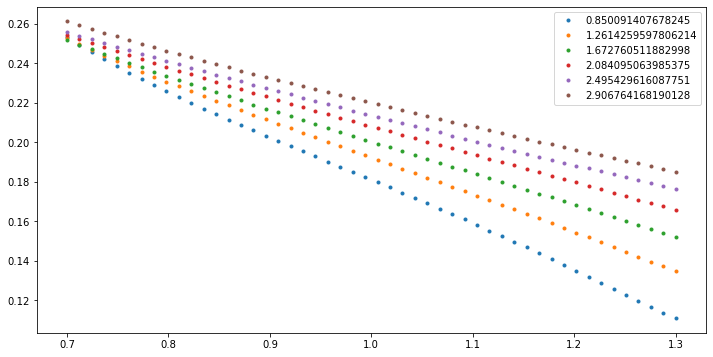

In [419]:
plt.figure(figsize=(12,6))
for i in range(10,expiries.shape[0],5):
    plt.plot(strikes, vols_heston[i,:], '.', label=str(expiries[i]))
plt.legend()

In [425]:
heston_grid_param = mktdata.VolatilityGridParametrization(expiries, strikes, vols_heston)
dc = mktdata.curves.DiscountCurve('dc', dt.datetime(2021,1,1), [dt.datetime(2021,1,1)],[1.0])
heston_surface = mktdata.VolatilitySurface('heston_surface', dt.datetime(2021,1,1), 
                          mktdata.EquityForwardCurve(1.0,dc,dc,dc), 
                         rivapy.enums.DayCounterType.Act365Fixed, heston_grid_param)

## Heston Local-Vol Model

In [327]:
#ssvi = mktdata.VolatilityParametrizationSSVI(expiries=[1.0/365, 30/365, 0.5, 1.0], fwd_atm_vols=[0.25, 0.3, 0.28, 0.25], rho=-0.9, eta=0.5, gamma=0.5)
import pickle

if False:
    with open('depp.pck', 'wb') as f:
        del heston_grid_param._pyvacon_obj
        pickle.dump(heston_grid_param, f)
heston_lv = models.HestonLocalVol(heston)
heston_lv.calibrate_MC(heston_grid_param,  x_strikes=strikes, time_grid=timegrid, n_sims=1000) 
lv = models.LocalVol.compute_local_var(heston_grid_param, strikes, timegrid)

AttributeError: 'VolatilityGridParametrization' object has no attribute '_pyvacon_obj'

In [195]:
heston_lv._stoch_local_variance = np.ones(shape=heston_lv._stoch_local_variance.shape)

TypeError: 'NoneType' object is not subscriptable

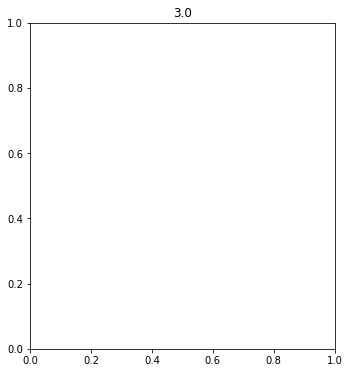

In [410]:
timepoint = -1
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title(str(timegrid[timepoint]))
plt.plot(strikes, np.sqrt(heston_lv._stoch_local_variance[timepoint]))
plt.subplot(1,2,2)
plt.plot(strikes, np.sqrt(lv[timepoint]))

In [196]:
simulated_values = np.empty((n_sims, 2))
simulated_values[:,0] = S0
simulated_values[:,1] = heston._initial_variance

paths = np.empty((timegrid.shape[0], n_sims, 2))
paths[0] = simulated_values

for i in range(1,timegrid.shape[0]):
    rnd = np.random.normal(size=(n_sims,2))
    paths[i] = heston_lv.apply_mc_step(simulated_values, timegrid[i-1], timegrid[i], rnd, inplace=True)
    
call_prices_heston_lv = np.empty((expiries.shape[0], strikes.shape[0]))
p = paths[10::30]

for i in range(expiries.shape[0]):
    for k in range(strikes.shape[0]):
        call_prices_heston_lv[i,k] = np.mean(np.maximum(p[i][:,0]-strikes[k],0.0))

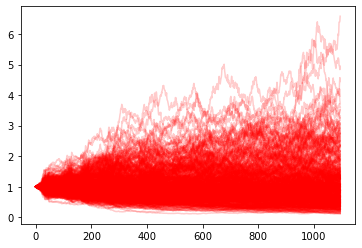

In [426]:
local_vol = models.LocalVol(heston_grid_param, np.linspace(0.5,1.5, 360), timegrid)
simulated_values = np.empty((n_sims, 1))
simulated_values[:,0] = S0

paths = np.empty((timegrid.shape[0], n_sims, 1))
paths[0] = simulated_values

for i in range(1,timegrid.shape[0]):
    rnd = np.random.normal(size=(n_sims,1))
    paths[i] = local_vol.apply_mc_step(simulated_values, timegrid[i-1], timegrid[i], rnd, inplace=True)
call_prices_local_vol = np.empty((expiries.shape[0], strikes.shape[0]))
p = paths[10::30]

for i in range(expiries.shape[0]):
    for k in range(strikes.shape[0]):
        call_prices_local_vol[i,k] = np.mean(np.maximum(p[i][:,0]-strikes[k],0.0))
        
for i in range(500):
    plt.plot(paths[:,i,0],'-r', alpha=0.2)

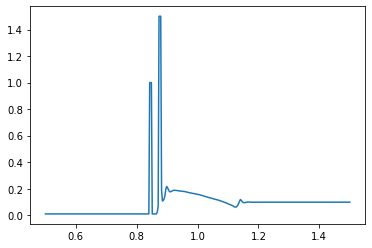

In [429]:
plt.plot(np.linspace(0.5,1.5,360),np.sqrt(local_vol._variance(0.1, np.linspace(0.5,1.5,360))))

In [427]:
#vols_heston_lv = calc_imlied_vol_grid(expiries, strikes, call_prices_heston_lv)
vols_local_vol = calc_imlied_vol_grid(expiries, strikes, call_prices_local_vol)

Extrapolation necessary for expiry 0


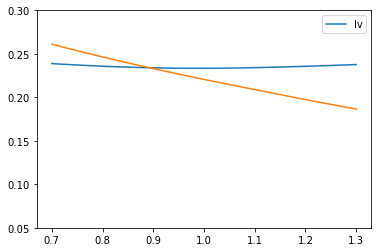

In [428]:
expiry=-1
#plt.plot(strikes, vols_heston[expiry], label='heston')
#plt.plot(strikes, vols_heston_lv[expiry], label='heston-lv')
plt.plot(strikes, vols_local_vol[expiry], label='lv')
plt.plot(strikes, [heston_grid_param.calc_implied_vol(expiries[expiry], s) for s in strikes])
plt.ylim((0.05,0.3))
plt.legend();


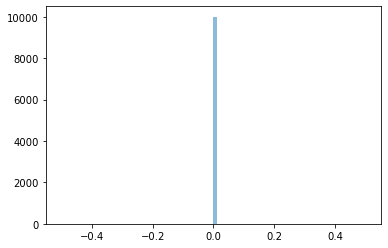

In [82]:
#plt.hist(p[0][:,0], alpha=0.5, bins=100);
plt.hist(paths[11][:,0], alpha=0.5, bins=100);

In [28]:
def calc_imlied_vol_grid(expiries, strikes, call_prices):
    vols = np.zeros((expiries.shape[0],strikes.shape[0]))
    for i in range(expiries.shape[0]):
        for j in range(strikes.shape[0]):
            try:
                vols[i,j] = analytics.compute_implied_vol_Buehler(strikes[j], maturity=expiries[i], 
                                                                price=call_prices[i, j], min_vol=0.01)
            except:
                pass

    for i in range(expiries.shape[0]):
        extrapolation = False
        for j in range(int(strikes.shape[0]/2),strikes.shape[0]):
            if vols[i,j] <1e-6:
                vols[i,j] = vols[i,j-1]
                extrapolation = True
        for j in range(23,-1,-1):
            if vols[i,j] <1e-6:
                vols[i,j] = vols[i,j+1]
                extrapolation = True
        if extrapolation:
            print('Extrapolation necessary for expiry ' + str(i))
    return vols

In [29]:
heston = models.HestonModel(long_run_variance=0.3**2, 
                            mean_reversion_speed=0.5, 
                            vol_of_vol=0.2, 
                            initial_variance=0.15**2, 
                            correlation = -0.95)
x_strikes = np.linspace(0.5,1.5, num=240)
time_grid = np.linspace(1.0/365.0,1.0, num=120) 
call_prices = heston.call_price(1.0, heston._initial_variance, x_strikes, time_grid)
vols_heston = calc_imlied_vol_grid(time_grid, x_strikes, call_prices)   


Extrapolation necessary for expiry 0
Extrapolation necessary for expiry 1
Extrapolation necessary for expiry 2
Extrapolation necessary for expiry 3
Extrapolation necessary for expiry 4
Extrapolation necessary for expiry 5
Extrapolation necessary for expiry 6
Extrapolation necessary for expiry 7
Extrapolation necessary for expiry 8
Extrapolation necessary for expiry 9
Extrapolation necessary for expiry 10
Extrapolation necessary for expiry 11
Extrapolation necessary for expiry 12
Extrapolation necessary for expiry 13
Extrapolation necessary for expiry 14
Extrapolation necessary for expiry 15
Extrapolation necessary for expiry 16
Extrapolation necessary for expiry 17
Extrapolation necessary for expiry 18
Extrapolation necessary for expiry 19
Extrapolation necessary for expiry 20
Extrapolation necessary for expiry 21
Extrapolation necessary for expiry 22
Extrapolation necessary for expiry 23
Extrapolation necessary for expiry 24
Extrapolation necessary for expiry 25
Extrapolation necessar

In [24]:
heston_grid_param = mktdata.VolatilityGridParametrization(time_grid, x_strikes, vols_heston)
heston_lv = models.HestonLocalVol(heston)
heston_lv.calibrate_MC(heston_grid_param, x_strikes, time_grid, n_sims=1000)

Extrapolation necessary for expiry 0
Extrapolation necessary for expiry 1
Extrapolation necessary for expiry 2
Extrapolation necessary for expiry 3
Extrapolation necessary for expiry 4
Extrapolation necessary for expiry 5
Extrapolation necessary for expiry 6
Extrapolation necessary for expiry 7
Extrapolation necessary for expiry 8
Extrapolation necessary for expiry 9
Extrapolation necessary for expiry 10
Extrapolation necessary for expiry 11
Extrapolation necessary for expiry 12
Extrapolation necessary for expiry 13
Extrapolation necessary for expiry 14
Extrapolation necessary for expiry 15
Extrapolation necessary for expiry 16
Extrapolation necessary for expiry 17
Extrapolation necessary for expiry 18
Extrapolation necessary for expiry 19
Extrapolation necessary for expiry 20
Extrapolation necessary for expiry 21
Extrapolation necessary for expiry 22
Extrapolation necessary for expiry 23
Extrapolation necessary for expiry 24
Extrapolation necessary for expiry 25
Extrapolation necessar

/home/doeltz/doeltz/development/RiVaPy/rivapy/numerics/kernel_regression.py:105: RuntimeWarning: invalid value encountered in true_divide
  return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)
/home/doeltz/doeltz/development/RiVaPy/rivapy/models/__init__.py:405: RuntimeWarning: divide by zero encountered in true_divide
  stoch_local_variance[i] = local_var[i]/kr.predict(x_strikes.reshape((-1,1)))


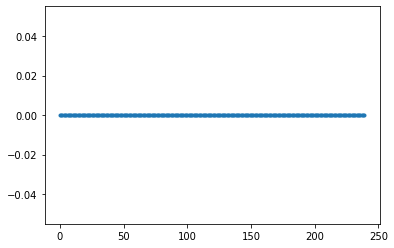

In [31]:
plt.plot(vols_heston[100,:],'.')